In [1]:
import pandas as pd 
import numpy as np 
import configparser
import os
import seaborn as sns
import plotly_express as px

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

import nltk 

from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne

config = configparser.ConfigParser()
config.read("..//env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
base_path = config['DEFAULT']['base_path']
code_dir = config['DEFAULT']['code_dir']

data_prefix = 'Maha'
out_path = f'{output_dir}/{data_prefix}'
OHCO = ['book_id','chap_id','sec_id','para_num', 'sent_num', 'token_num']


os.chdir(code_dir)
import preprocess
import bow_analysis
os.chdir(base_path + "//notebooks")

SENTS = OHCO[:5]
PARA = OHCO[:4]
SECS = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [2]:
w2v_params = dict(
    window = 2,
    vector_size = 200,
    min_count = 108, # THIS LIMITS OUR VOCAB
    workers = 8
)

In [3]:
CORPUS = pd.read_csv(fr"{output_dir}\F2\{data_prefix}-CORPUS.csv", sep="|").set_index(OHCO)

VOCAB = pd.read_csv(fr"{output_dir}\CHAP_BOW\{data_prefix}-VOCAB2.csv", sep="|").set_index('term_str')
VOCAB = VOCAB[~VOCAB.index.isna()]
VOCAB

,term_rank,index,n,n_chars,p,i,s,h,stop,stem_porter,...,n_pos,cat_pos,df,idf,dp,di,dh,dfidf,tfidf_mean,tfidf_sum
term_str,,,,,,,,,,,,,,,,,,,,,
the,1,26639,163915,3,6.803053e-02,3.877674,1.469928e+01,0.263800,1,the,...,2,"{'VB', 'DT'}",99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
of,2,18678,129501,2,5.374750e-02,4.217659,1.860552e+01,0.226689,1,of,...,1,{'IN'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
and,3,3003,95887,3,3.979650e-02,4.651215,2.512784e+01,0.185102,1,and,...,1,{'CC'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
that,4,26637,47382,4,1.966521e-02,5.668211,5.085123e+01,0.111467,1,that,...,6,"{'RB', 'NNP', 'VBP', 'IN', 'WDT', 'DT'}",99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
to,5,26929,43192,2,1.792621e-02,5.801786,5.578424e+01,0.104004,1,to,...,1,{'TO'},99.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jamvunadi,30678,14683,1,9,4.150354e-07,21.200262,2.409433e+06,0.000009,0,jamvunadi,...,1,{'NNP'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,6.657043e-06,0.000659
jamvuvan,30679,14685,1,8,4.150354e-07,21.200262,2.409433e+06,0.000009,0,jamvuvan,...,1,{'NNP'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,3.396216e-06,0.000336
janani,30680,14693,1,6,4.150354e-07,21.200262,2.409433e+06,0.000009,0,janani,...,1,{'NN'},1.0,6.629357,0.010101,6.629357,0.066963,6.629357,2.544436e-07,0.000025


In [4]:
BAG = OHCO[:2]

docs = CORPUS.dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

docs = [doc for doc in docs if len(doc) > 1]
docs[:2]

[['anukramanika',
  'parva',
  'om',
  'having',
  'bowed',
  'down',
  'to',
  'narayana',
  'and',
  'nara',
  'the',
  'most',
  'exalted',
  'male',
  'being',
  'and',
  'also',
  'to',
  'the',
  'goddess',
  'saraswati',
  'must',
  'the',
  'word',
  'jaya',
  'be',
  'uttered',
  'ugrasrava',
  'the',
  'son',
  'of',
  'lomaharshana',
  'surnamed',
  'sauti',
  'wellversed',
  'in',
  'the',
  'puranas',
  'bending',
  'with',
  'humility',
  'one',
  'day',
  'approached',
  'the',
  'great',
  'sages',
  'of',
  'rigid',
  'vows',
  'sitting',
  'at',
  'their',
  'ease',
  'who',
  'had',
  'attended',
  'the',
  'twelve',
  'years',
  'sacrifice',
  'of',
  'saunaka',
  'surnamed',
  'kulapati',
  'in',
  'the',
  'forest',
  'of',
  'naimisha',
  'those',
  'ascetics',
  'wishing',
  'to',
  'hear',
  'his',
  'wonderful',
  'narrations',
  'presently',
  'began',
  'to',
  'address',
  'him',
  'who',
  'had',
  'thus',
  'arrived',
  'at',
  'that',
  'recluse',
  'abo

In [5]:
vocab = Dictionary(docs)

In [6]:
vocab

In [7]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [8]:
model.wv.vectors

array([[ 0.1297988 , -0.04980799, -0.17183876, ...,  0.10574731,
        -0.00516622,  0.22513086],
       [-0.08564603,  0.00124787, -0.6874725 , ..., -0.6288251 ,
        -0.3227097 , -0.53015596],
       [-0.19083956,  0.59783375, -0.13468726, ..., -0.08390567,
         0.01606269, -0.14047888],
       ...,
       [ 0.08237319,  0.06634344, -0.11471155, ..., -0.07424738,
        -0.09495793, -0.0195091 ],
       [ 0.06108551,  0.08749758, -0.07440059, ..., -0.05741732,
        -0.13541275, -0.02939336],
       [-0.1161569 , -0.05435123,  0.05214289, ..., -0.10308012,
        -0.19709435,  0.01254036]], dtype=float32)

In [9]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        # print(f"No - {w}")
        vec = None
    return vec

WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
WV

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
term_str,,,,,,,,,,,,,,,,,,,,,
the,0.129799,-0.049808,-0.171839,0.698650,0.175317,-0.218636,0.058364,0.334454,-0.239919,0.091326,...,-0.745336,0.062818,-0.018265,-0.324902,-0.268591,-0.048194,-0.214513,0.105747,-0.005166,0.225131
of,-0.085646,0.001248,-0.687473,-0.465769,0.615773,-0.130529,-0.277529,-0.435048,-0.208021,0.843034,...,-0.277811,-0.310709,-0.091836,-0.319793,0.182934,-0.301401,0.040508,-0.628825,-0.322710,-0.530156
and,-0.190840,0.597834,-0.134687,-0.444651,-0.186154,0.412969,0.049148,-0.041001,-0.409441,0.039027,...,0.667240,0.583532,-0.124051,0.377678,0.090449,-0.102884,0.006278,-0.083906,0.016063,-0.140479
that,0.793018,-0.046268,0.361560,-0.101655,0.194526,-0.440904,0.143588,-0.038695,0.279738,-0.045586,...,-0.510943,-0.089276,-0.521985,0.455834,0.180016,0.735037,-0.545936,0.276004,0.305227,-0.350180
to,-0.365411,0.215707,0.031628,0.615954,0.548965,-0.316071,0.461195,-0.674611,-0.501044,0.553945,...,-0.981480,0.593356,0.814884,0.778310,0.575124,-0.391495,-0.343729,0.596097,1.125704,0.037349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kali,0.082373,0.066343,-0.114712,0.091445,0.032434,0.101094,0.130527,0.297435,-0.001022,0.189111,...,-0.049323,0.040844,-0.131571,0.060269,0.016927,0.115430,-0.035195,-0.074247,-0.094958,-0.019509
shame,-0.116157,-0.054351,0.052143,0.251189,0.001892,0.166197,0.095595,0.239805,-0.041909,-0.003286,...,0.199139,0.163330,-0.138700,0.011928,0.102555,0.179384,0.021005,-0.103080,-0.197094,0.012540
increase,-0.022441,-0.006331,0.028379,0.005083,0.040987,0.102948,0.060105,0.172608,-0.006038,0.070647,...,0.190867,0.048854,-0.108184,0.010964,0.071438,0.116215,-0.054803,-0.150558,-0.105032,-0.017407


In [10]:
WV.to_csv(fr"{output_dir}/Word2Vec_Results/{data_prefix}-W2V.csv", sep="|")

In [11]:
PP = 108
tsne_engine = tsne(
    perplexity=PP, 
    n_components=2, 
    init='pca', 
    n_iter=2500, 
    random_state=108)

In [12]:
tsne_model = tsne_engine.fit_transform(WV.to_numpy())

C:\Users\vishg\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [13]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=WV.index)
TSNE

,x,y
term_str,,
the,4.046956,-5.264687
of,8.680503,1.101607
and,11.100507,0.695675
that,-5.335272,-7.365601
to,-19.770967,-2.916258
...,...,...
kali,2.018549,-6.003542
shame,-3.316276,4.289020
increase,-4.803478,0.897099


In [14]:
TSNE.reset_index()[TSNE.reset_index()['term_str'].apply(lambda x: x[:3]=='div')]

,term_str,x,y
213,diverse,17.212420,1.254196
745,divine,1.268449,-6.045267
1100,division,5.221714,2.580867
1134,divested,-6.569506,5.763046
1295,divisions,11.790893,-2.334645


In [15]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='RB']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [16]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='JJ']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [17]:
X = TSNE.join(VOCAB, how='left')
X = X[X['max_pos_group']=='NN']
px.scatter(X.reset_index(), 'x', 'y', 
        text='term_str', 
        color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [26]:
X = TSNE.join(VOCAB, how='left')
px.scatter(X.reset_index(), 'x', 'y', 
           title="t-SNE Reduced Plot of Word2Vec Embeddings",
        text='term_str', 
        size="dfidf",
        # color='max_pos_group', 
        hover_name='term_str',          
        height=1000,
        width=1200)\
    .update_traces(
        mode='markers+text', 
        textfont=dict(color='black', size=14, family='Arial'),
        textposition='top center')

In [19]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [20]:
get_most_similar('defeat',3)

,term,sim
0,kingdom,0.546535
1,journey,0.527713
2,victory,0.525019
3,exile,0.522807
4,foe,0.513998
5,fears,0.512921
6,sovereignty,0.509491
7,service,0.502933
8,benefit,0.498071
9,order,0.494314


In [21]:
complete_analogy('man', 'prince', 'woman', 5)

,term,sim
0,princess,0.759130
1,host,0.711333
2,ruler,0.706800
3,daughter,0.681577
4,line,0.680609


In [22]:
import sys
sys.path.append(code_dir)
from hac2 import HAC

<Figure size 640x480 with 0 Axes>

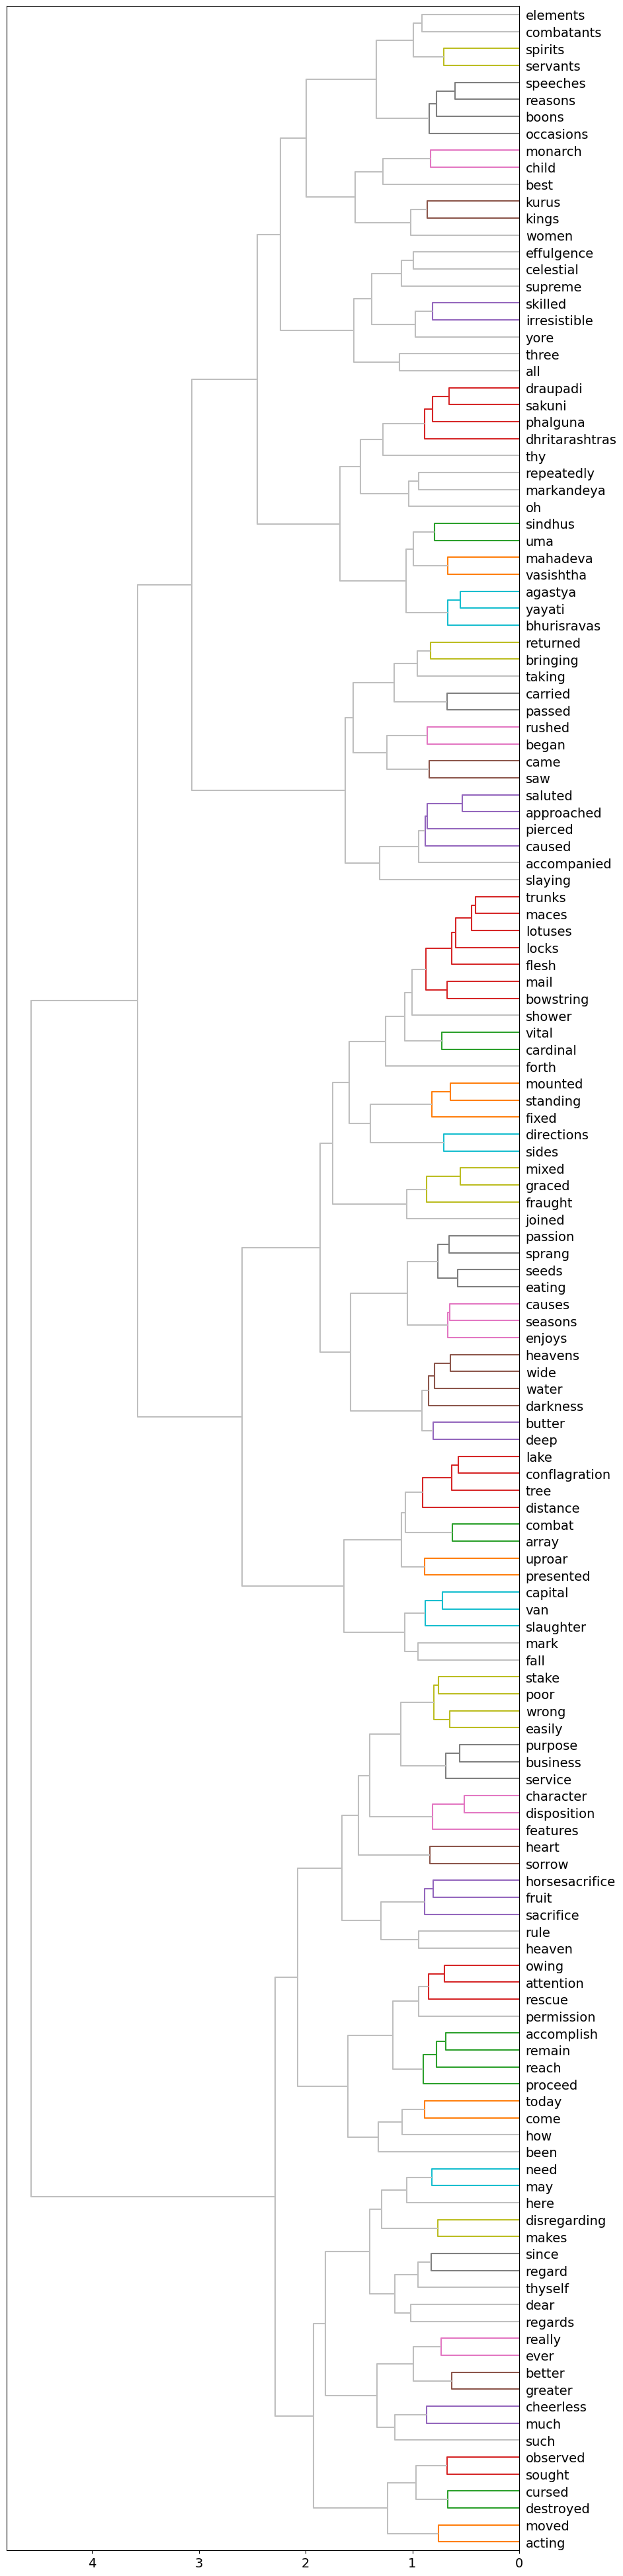

In [23]:
HAC(WV.sample(150)).plot()